Fragments of the code ate taken from book E. Lewinson «Python for Finance Cookbook» ISBN 978-1-78961-851-8

In [56]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
import seaborn as sns
import warnings

# settings 
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=InterpolationWarning)
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]

<h1>Utils</h1>

In [31]:
# utils

def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary
    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''

    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']

    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)

    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results


def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity
    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary
    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''

    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)

    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results


def test_autocorrelation(x, n_lags=40, alpha=0.05, h0_type='c'):
    '''
    Function for testing the stationarity of a series by using:
    * the ADF test
    * the KPSS test
    * ACF/PACF plots
    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    n_lags : int
        The number of lags for the ACF/PACF plots
    alpha : float
        Significance level for the ACF/PACF plots
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the ACF/PACF plot
    '''

    adf_results = adf_test(x)
    kpss_results = kpss_test(x, h0_type=h0_type)

    print('ADF test statistic: {:.2f} (p-val: {:.2f})'.format(adf_results['Test Statistic'],
                                                             adf_results['p-value']))
    print('KPSS test statistic: {:.2f} (p-val: {:.2f})'.format(kpss_results['Test Statistic'],
                                                              kpss_results['p-value']))

    fig, ax = plt.subplots(2, figsize=(16, 8))
    plot_acf(x, ax=ax[0], lags=n_lags, alpha=alpha)
    plot_pacf(x, ax=ax[1], lags=n_lags, alpha=alpha)

    return fig

<h1>Uploading data and setting parameters</h1>

In [61]:
TRAIN_DATE_START = '2018-09-01'
TRAIN_DATE_END = '2020-08-20'
PREDICT_DATE_START = '2020-08-21'
PREDICT_DATE_END = '2020-09-10'
# Aeroflot asset price choosen for predctions
TICKER = 'AFLT.ME'

In [33]:
df = yf.download(TICKER, start=TRAIN_DATE_START, end=TRAIN_DATE_END, adjusted=True, progress=False)
df = df.rename(columns={'Adj Close': 'adj_close'}).adj_close

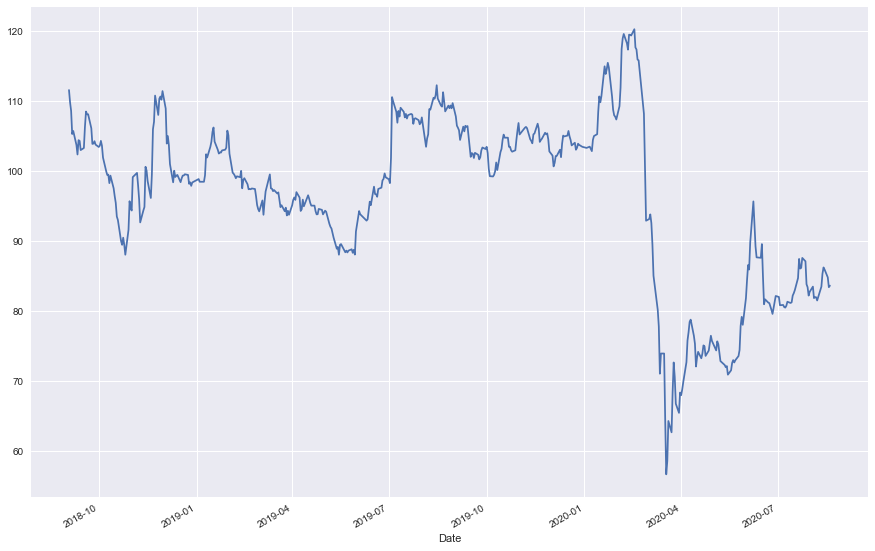

In [34]:
df.plot()

<h1>Checking stationarity</h1><p>
Augmented Dickey-Fuller Method
    
Kwiatkowski-Phillips-Schmidt-Shin Method

ADF test statistic: -2.58 (p-val: 0.10)
KPSS test statistic: 0.75 (p-val: 0.01)


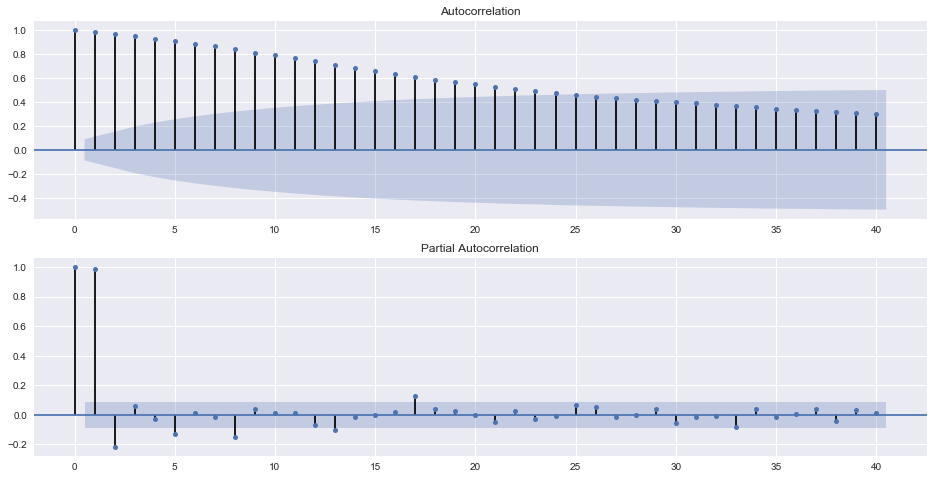

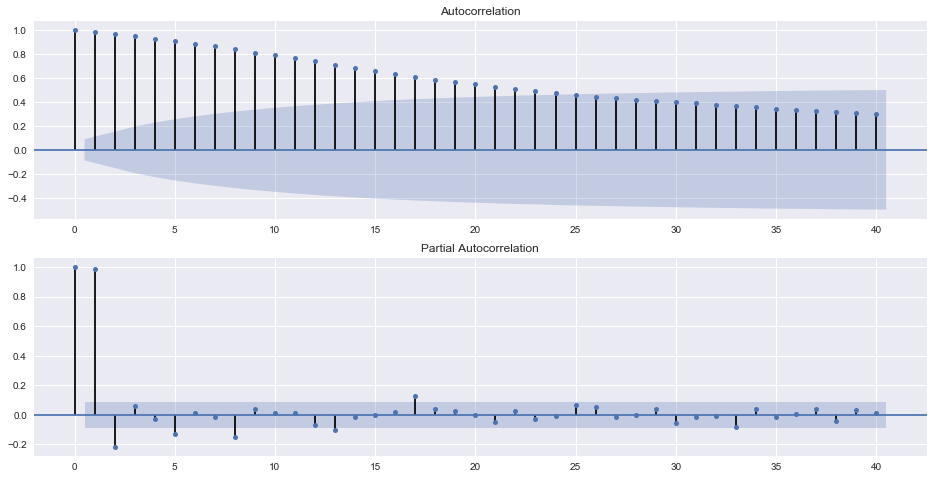

In [35]:
test_autocorrelation(df)

Unfortunately we were not able to refute the null hypothesis about the stationarity of the series
 by using ADF-method. We will check first order integrated series.

<h1>Calculating first order integrated series</h1>

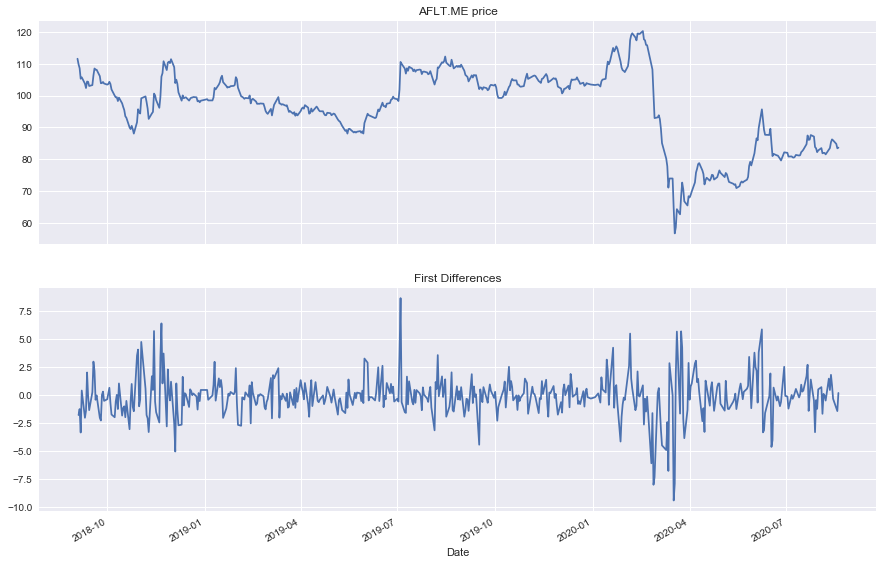

In [36]:
df_diff = df.diff().dropna()
fig, ax = plt.subplots(2, sharex=True)
df.plot(title = "{} price".format(TICKER), ax=ax[0])
df_diff.plot(ax=ax[1], title='First Differences')

ADF test statistic: -6.70 (p-val: 0.00)
KPSS test statistic: 0.04 (p-val: 0.10)


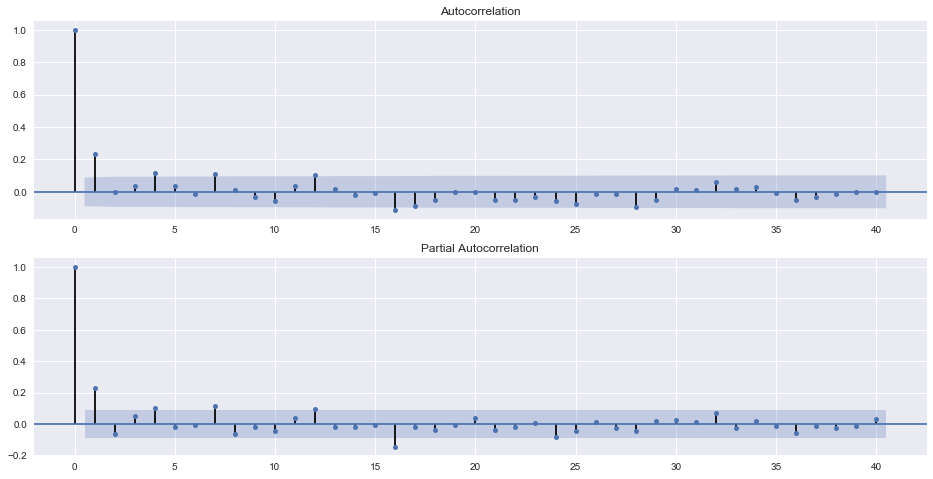

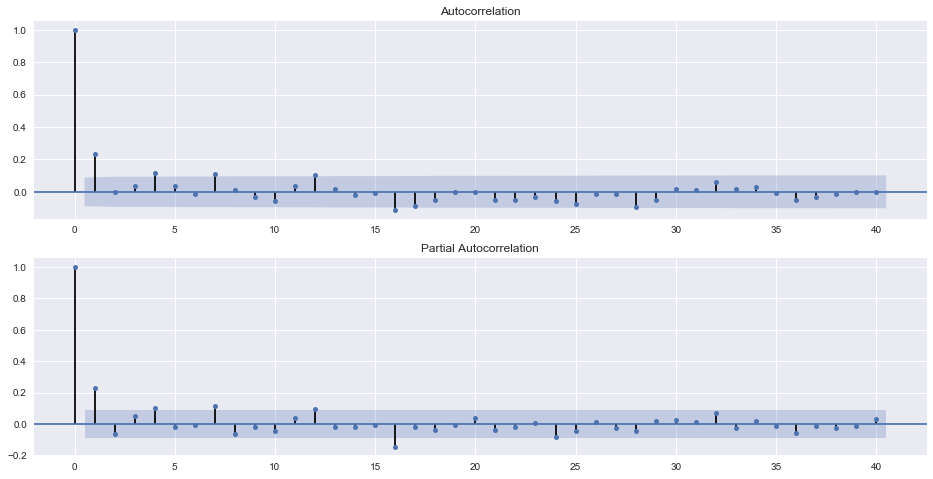

In [37]:
test_autocorrelation(df_diff)

Отлично, стационарность подтверждена

<h1>Manual ARIMA model</h1><p>
From the ACF and PACF graphs, we can assume that the order p, q should be chosen equal to 1 based on the numbers of the last lags that fall outside the confidence interval

In [ ]:
arima = ARIMA(df, order=(16, 1, 16)).fit(disp=0)
arima.summary()

<h1>Tails investigation</h1>

In [39]:
def arima_diagnostics(resids, n_lags=40):
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')
    
    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.distplot(resids_nonmissing, hist=True, kde=True,
    norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
    
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')
    
    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')
    return fig

Tails

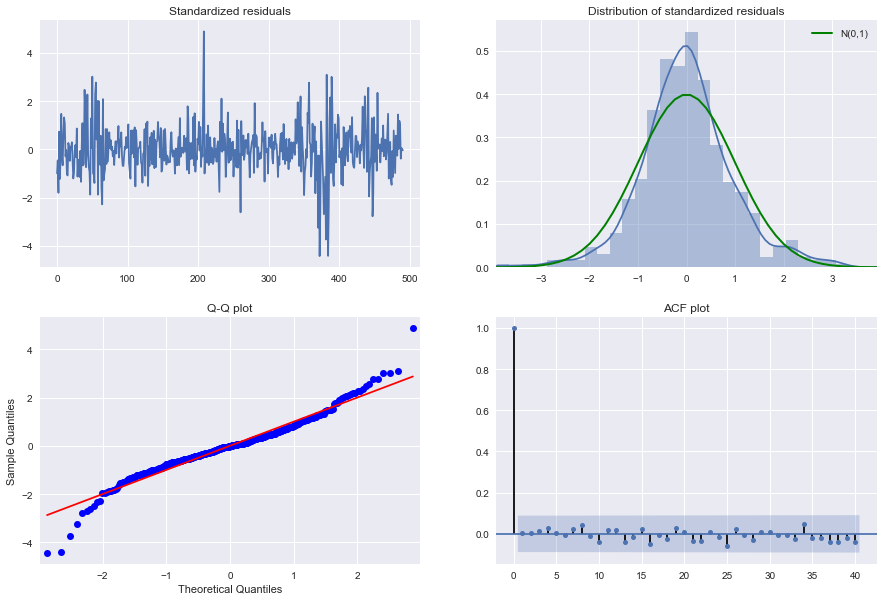

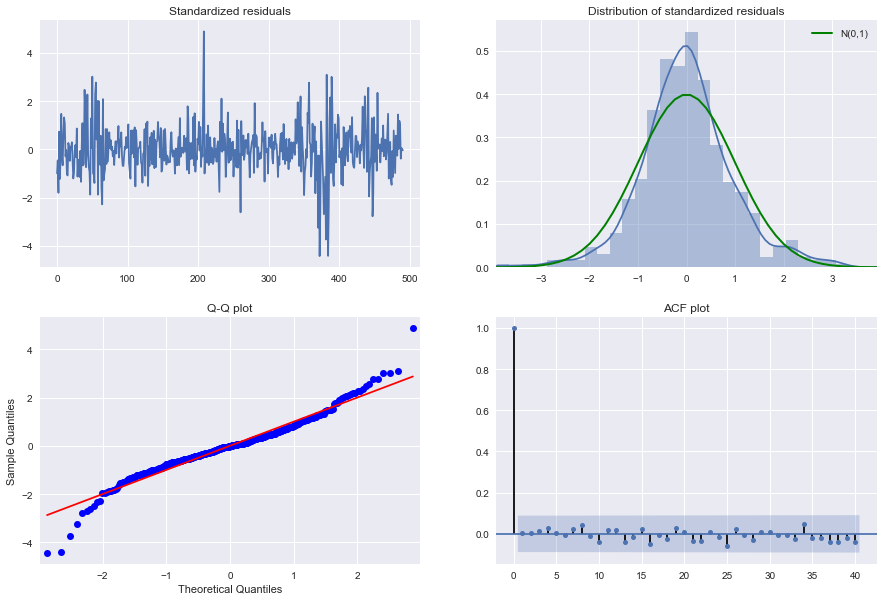

In [40]:
arima_diagnostics(arima.resid, 40)

The distribution is close to normal. There is no strong correlation between the lags.

[Text(0, 0.5, 'p-value'),
 Text(0.5, 0, 'Lag'),
 Text(0.5, 1.0, "Ljung-Box test's results")]

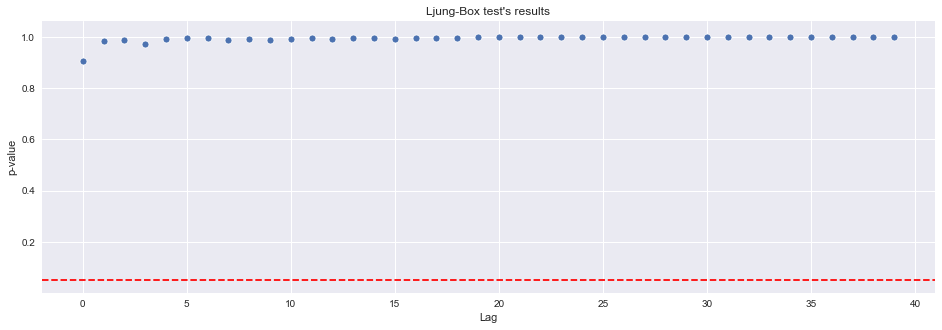

In [41]:
ljung_box_results = acorr_ljungbox(arima.resid)
fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])),
y=ljung_box_results[1],
ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
xlabel='Lag',
ylabel='p-value')

<h1>Parameters tuning using AIC-criterion</h1>

In [42]:
min_aic = 99999
min_model = ''
for p in range(9):
    for q in range(9):
        try:
            arima = ARIMA(df, order=(p, 1, q)).fit(disp=0)
            print('ARIMA({},1,{}), AIC:{}'.format(p,q,arima.aic))
            if arima.aic < min_aic:
                min_aic = arima.aic
                min_model = 'ARIMA({},1,{})'.format(p,q)
        except:
            print('ARIMA({},1,{}), Model error'.format(p,q))
print('Min AIC:{}, Min Model:{}'.format(min_aic, min_model))

ARIMA(0,1,0), AIC:1996.2472066399341
ARIMA(0,1,1), AIC:1968.9747146218624
ARIMA(0,1,2), AIC:1970.9724518546177
ARIMA(0,1,3), AIC:1972.84613114597
ARIMA(0,1,4), AIC:1969.4543576021863
ARIMA(0,1,5), AIC:1969.458078077288
ARIMA(0,1,6), AIC:1970.4181622292035
ARIMA(0,1,7), AIC:1965.0584456201154
ARIMA(0,1,8), AIC:1966.6027268387766
ARIMA(1,1,0), AIC:1971.0552822903524
ARIMA(1,1,1), AIC:1970.972669805778
ARIMA(1,1,2), AIC:1971.8209946585976
ARIMA(1,1,3), Model error
ARIMA(1,1,4), Model error
ARIMA(1,1,5), Model error
ARIMA(1,1,6), Model error
ARIMA(1,1,7), Model error
ARIMA(1,1,8), Model error
ARIMA(2,1,0), AIC:1971.2587593694082
ARIMA(2,1,1), AIC:1972.9319435126554
ARIMA(2,1,2), AIC:1973.279855482485
ARIMA(2,1,3), Model error
ARIMA(2,1,4), AIC:1972.132123621881
ARIMA(2,1,5), Model error
ARIMA(2,1,6), Model error
ARIMA(2,1,7), Model error
ARIMA(2,1,8), Model error
ARIMA(3,1,0), AIC:1971.8110322938116
ARIMA(3,1,1), AIC:1970.8823375927068
ARIMA(3,1,2), AIC:1972.3800451901425
ARIMA(3,1,3), AIC

In [43]:
arima2 = ARIMA(df, order=(7, 1, 6)).fit(disp=0)
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  491
Model:                 ARIMA(7, 1, 6)   Log Likelihood                -965.697
Method:                       css-mle   S.D. of innovations              1.713
Date:                Tue, 01 Sep 2020   AIC                           1961.394
Time:                        16:18:48   BIC                           2024.340
Sample:                             1   HQIC                          1986.113
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0592      0.108     -0.549      0.583      -0.271       0.152
ar.L1.D.adj_close    -0.1356      0.124     -1.097      0.273      -0.378       0.107
ar.L2.D.adj_close    -0.6158      0.120     -5.133      0.000      -0.851      -0.381
ar.L3.D.adj_close    -0.3194      0.045     -7.067      0.000      -0.408      -0.231
ar.L4.D.adj_close    -0.6880      0.054    -12.653      0.000      -0.795      -0.581
ar.L5.D.adj_close    -0.0925      0.123     -0.754      0.451      -0.333       0.148
ar.L6.D.adj_close    -0.6850      0.097     -7.027      0.000      -0.876      -0.494
ar.L7.D.adj_close     0.2755      0.051      5.431      0.000       0.176       0.375
ma.L1.D.adj_close     0.3950      0.121      3.277      0.001       0.159       0.631
ma.L2.D.adj_close     0.6516      0.147      4.441      0.000       0.364       0.939
ma.L3.D.adj_close     0.4940      0.040     12.341      0.000       0.416       0.572
ma.L4.D.adj_close     0.9153      0.039     23.453      0.000       0.839       0.992
ma.L5.D.adj_close     0.3289      0.135      2.435      0.015       0.064       0.594
ma.L6.D.adj_close     0.7705      0.135      5.707      0.000       0.506       1.035
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8238           -0.5808j            1.0080           -0.4023
AR.2           -0.8238           +0.5808j            1.0080            0.4023
AR.3           -0.0779           -1.0770j            1.0798           -0.2615
AR.4           -0.0779           +1.0770j            1.0798            0.2615
AR.5            0.6626           -0.7709j            1.0166           -0.1370
AR.6            0.6626           +0.7709j            1.0166            0.1370
AR.7            2.9648           -0.0000j            2.9648           -0.0000
MA.1            0.6646           -0.7472j            1.0000           -0.1343
MA.2            0.6646           +0.7472j            1.0000            0.1343
MA.3           -0.8086           -0.5883j            1.0000           -0.3999
MA.4           -0.8086           +0.5883j            1.0000            0.3999
MA.5           -0.0694           -1.1371j            1.1392           -0.2597
MA.6           -0.0694           +1.1371j            1.1392            0.2597
-----------------------------------------------------------------------------
"""

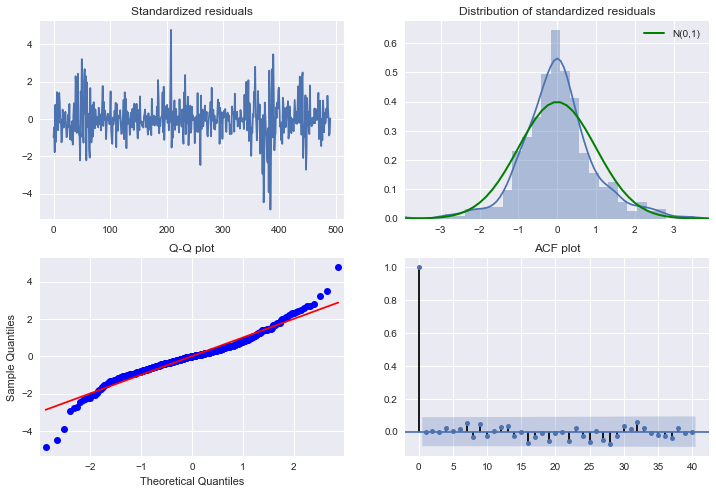

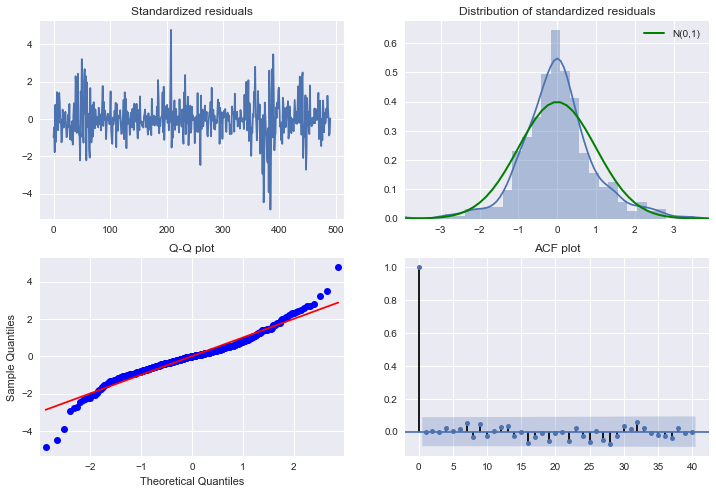

In [60]:
arima_diagnostics(arima2.resid, 40)

[Text(0, 0.5, 'p-value'),
 Text(0.5, 0, 'Lag'),
 Text(0.5, 1.0, "Ljung-Box test's results")]

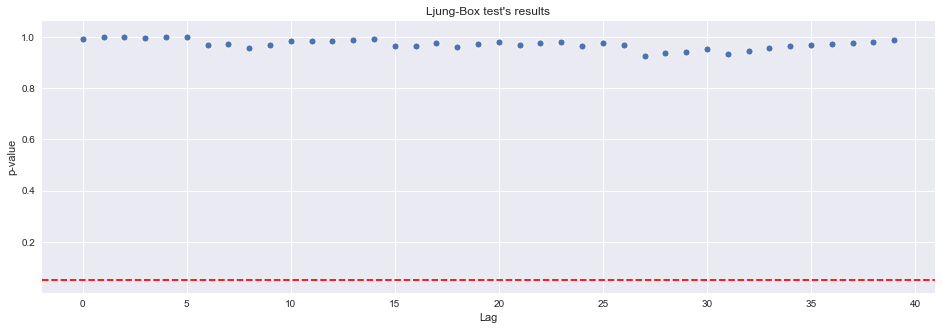

In [45]:
ljung_box_results = acorr_ljungbox(arima2.resid)
fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])),
y=ljung_box_results[1],
ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
xlabel='Lag',
ylabel='p-value')

<h1>Predictions</h1>

In [63]:
df = yf.download(TICKER, start=PREDICT_DATE_START, end=PREDICT_DATE_END, adjusted=True, progress=False)
test = df.rename(columns={'Adj Close': 'adj_close'}).adj_close

In [64]:
n_forecasts = len(test)
arima_pred = arima.forecast(n_forecasts)
arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']), pd.DataFrame(arima_pred[2], columns=['ci_lower','ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)
arima_pred

,prediction,ci_lower,ci_upper
Date,,,
2020-08-21,83.499713,80.114338,86.885088
2020-08-24,83.645738,78.231651,89.059826
2020-08-25,83.485509,76.600968,90.370050
2020-08-26,83.079485,75.040016,91.118954
2020-08-27,83.573119,74.331411,92.814827
2020-08-28,83.551504,73.321762,93.781246
2020-08-31,83.546673,72.436205,94.657141
2020-09-01,83.369408,71.365503,95.373313
2020-09-02,83.168680,70.357362,95.979998


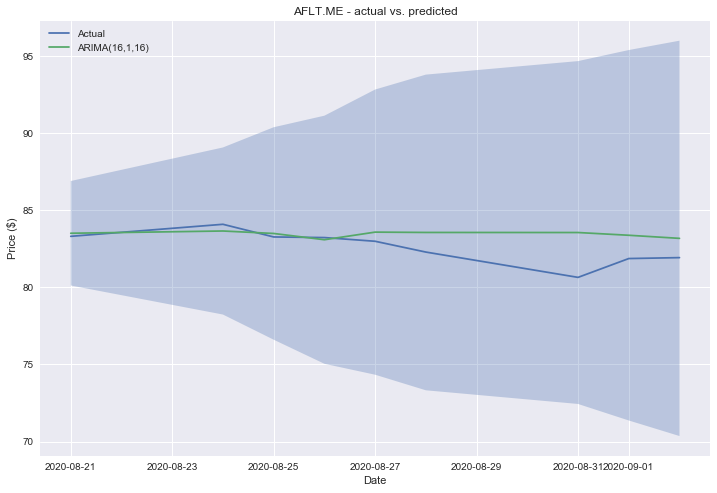

In [65]:
fig, ax = plt.subplots(1)
ax = sns.lineplot(data=test, label='Actual')
ax.plot(arima_pred.prediction, label='ARIMA(16,1,16)')
ax.fill_between(arima_pred.index, arima_pred.ci_lower, arima_pred.ci_upper, alpha=0.3)
ax.set(title="{} - actual vs. predicted".format(TICKER), xlabel='Date', ylabel='Price ($)')
ax.legend(loc='upper left')

In [66]:
arima_pred2 = arima2.forecast(n_forecasts)
arima_pred2 = [pd.DataFrame(arima_pred2[0], columns=['prediction']), pd.DataFrame(arima_pred2[2], columns=['ci_lower','ci_upper'])]
arima_pred2 = pd.concat(arima_pred2, axis=1).set_index(test.index)
arima_pred2

,prediction,ci_lower,ci_upper
Date,,,
2020-08-21,83.957715,80.599480,87.315949
2020-08-24,83.375947,77.975428,88.776465
2020-08-25,82.790856,75.929902,89.651811
2020-08-26,82.030919,73.943879,90.117959
2020-08-27,81.898062,72.515094,91.281029
2020-08-28,82.255631,71.690229,92.821032
2020-08-31,82.651714,71.072244,94.231184
2020-09-01,83.284746,70.736028,95.833464
2020-09-02,83.050009,69.625460,96.474558


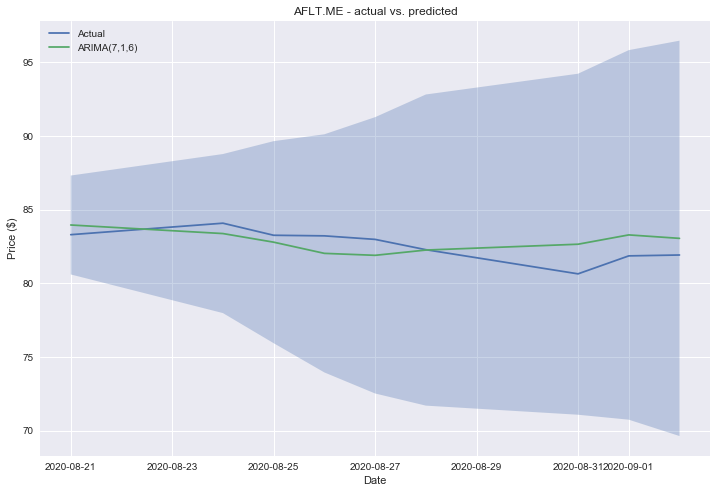

In [67]:
fig, ax = plt.subplots(1)
ax = sns.lineplot(data=test, label='Actual')
ax.plot(arima_pred2.prediction, label='ARIMA(7,1,6)')
ax.fill_between(arima_pred2.index, arima_pred2.ci_lower, arima_pred2.ci_upper, alpha=0.3)
ax.set(title="{} - actual vs. predicted".format(TICKER), xlabel='Date', ylabel='Price ($)')
ax.legend(loc='upper left')

<h1>Metrics</h1>

In [51]:
from sklearn.metrics import r2_score
import ml_metrics as metrics

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [52]:
rmse1 = metrics.rmse(test, arima_pred.prediction)
rmse2 = metrics.rmse(test, arima_pred2.prediction)
mape1 = mape(test, arima_pred.prediction)
mape2 = mape(test, arima_pred2.prediction)
print('ARIMA(7,1,7) RMSE:{}'.format(rmse1))
print('ARIMA(5,1,5) RMSE:{}'.format(rmse2))
print('ARIMA(7,1,7) MAPE:{}'.format(mape1))
print('ARIMA(5,1,5) MAPE:{}'.format(mape2))

ARIMA(7,1,7) RMSE:0.8365716516814613
ARIMA(5,1,5) RMSE:0.7892207589213739
ARIMA(7,1,7) MAPE:0.7000095746193207
ARIMA(5,1,5) MAPE:0.8338409580672562
ARIMA(7,1,7) MASE:0.09657762129659829
ARIMA(5,1,5) MASE:0.11576978992619796
